## Data 100 Final Project: COVID 19 Dataset


In [74]:
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

from sklearn.linear_model import LinearRegression

#Import Datasets
counties = pd.read_csv('abridged_couties.csv')
deaths = pd.read_csv('time_series_covid19_deaths_US.csv')
cases = pd.read_csv('time_series_covid19_confirmed_US.csv')
states = pd.read_csv('4.18states.csv')

## Data Cleaning on COVID Datasets

### States Dataframe

For data cleaning, a good starting point is to check for null and missing values and interpret what they may mean, before replacing them with any particular value.

In [75]:
# Check for how many missing values are in every column
states.isnull().sum()

Province_State           0
Country_Region           0
Last_Update             83
Lat                      5
Long_                    5
Confirmed                0
Deaths                   0
Recovered               24
Active                   1
FIPS                    82
Incident_Rate            5
People_Tested           84
People_Hospitalized     91
Mortality_Rate           3
UID                      0
ISO3                     0
Testing_Rate            84
Hospitalization_Rate    91
dtype: int64

Replacing information like People_Hospitalized with zero may not be a great idea since we cannot assume there are no people hospitalized, hence, we can replace these missing values with the mean of that country in which specific state data is missing. We can tackle People_Hospitalized, Testing_Rate, Hospitalization_Rate, People_Tested in this way.

The cell below calculates how many of the total values for each country are not missing. If a value turns out to be zero that means all data points in People_Hospitalized is missing for that country.

In [76]:
countries = states['Country_Region'].value_counts().index.tolist()
people_hospitalization_country_nulls = {}
def usable_vals(col):
    dic = {}
    for country in countries:
           dic[country] = len(states.loc[states['Country_Region'] == country,col].isnull()) - sum(states.loc[states['Country_Region'] == country,col].isnull())
    return dic
People_Hospitalization_country_nulls = usable_vals('People_Hospitalized')
Hospitalization_Rate_country_nulls = usable_vals('Hospitalization_Rate')
print(Hospitalization_Rate_country_nulls == People_Hospitalization_country_nulls)
print('People_Hospitalized \n', usable_vals('People_Hospitalized'))
print('Hospitalization_Rate \n', usable_vals('Hospitalization_Rate'))
print('Testing_Rate \n', usable_vals('Testing_Rate'))
print('People Tested \n', usable_vals('People_Tested'))
print('Mortality Rate \n', usable_vals('Mortality_Rate'))

True
People_Hospitalized 
 {'US': 49, 'China': 0, 'Canada': 0, 'United Kingdom': 0, 'France': 0, 'Australia': 0, 'Netherlands': 0, 'Denmark': 0}
Hospitalization_Rate 
 {'US': 49, 'China': 0, 'Canada': 0, 'United Kingdom': 0, 'France': 0, 'Australia': 0, 'Netherlands': 0, 'Denmark': 0}
Testing_Rate 
 {'US': 56, 'China': 0, 'Canada': 0, 'United Kingdom': 0, 'France': 0, 'Australia': 0, 'Netherlands': 0, 'Denmark': 0}
People Tested 
 {'US': 56, 'China': 0, 'Canada': 0, 'United Kingdom': 0, 'France': 0, 'Australia': 0, 'Netherlands': 0, 'Denmark': 0}
Mortality Rate 
 {'US': 57, 'China': 33, 'Canada': 13, 'United Kingdom': 10, 'France': 10, 'Australia': 8, 'Netherlands': 4, 'Denmark': 2}


We notice that there is another null value in a country outside the US, so to see which country that is, we can instead of check the values that are not null to sum the values that are infact null.

In [77]:
mortality_dic = {}
for country in countries:
        mortality_dic[country] =  sum(states.loc[states['Country_Region'] == country,'Mortality_Rate'].isnull())
mortality_dic

{'US': 2,
 'China': 0,
 'Canada': 1,
 'United Kingdom': 0,
 'France': 0,
 'Australia': 0,
 'Netherlands': 0,
 'Denmark': 0}

Only the data for US contains values that will be usable so we can go ahead and replace the NaN values in the US data with the mean of that column in the US and from here note that we can only incorporate People_Hospitalized in analysis within the US.

In [78]:
def replace_nan_with_mean(country, col):
    arr = states.loc[states['Country_Region'] == country, col]
    arr_mean = arr.mean()
    arr.fillna(arr_mean, inplace=True)
    states.loc[states['Country_Region'] == country,col] = arr

replace_nan_with_mean('US','People_Hospitalized')
replace_nan_with_mean('US','Hospitalization_Rate')
replace_nan_with_mean('US','Testing_Rate')
replace_nan_with_mean('US','People_Tested')
replace_nan_with_mean('US','Mortality_Rate')

# There is still an uncovered NaN value in Mortality_Rate but this time in a different country so we can remove that. Namely, Canada.
replace_nan_with_mean('Canada','Mortality_Rate')

states.isnull().sum()
states.head()

,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,FIPS,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,UID,ISO3,Testing_Rate,Hospitalization_Rate
0,Alabama,US,2020-04-18 22:32:47,32.3182,-86.9023,4712,153,NaN,4559.0,1.0,100.492717,42538.0,620.000000,3.247029,84000001,USA,907.206961,13.157895
1,Alaska,US,2020-04-18 22:32:47,61.3707,-152.4044,314,9,147.0,305.0,2.0,52.530410,9655.0,39.000000,2.866242,84000002,USA,1615.226458,12.420382
2,American Samoa,US,NaN,-14.2710,-170.1320,0,0,NaN,NaN,60.0,0.000000,3.0,2327.122449,3.727277,16,ASM,5.391708,14.141068
3,Arizona,US,2020-04-18 22:32:47,33.7298,-111.4312,4724,180,539.0,4544.0,4.0,64.901548,51045.0,566.000000,3.810330,84000004,USA,701.291175,11.981372
4,Arkansas,US,2020-04-18 22:32:47,34.9697,-92.3731,1744,38,703.0,1706.0,5.0,67.361213,24141.0,291.000000,2.178899,84000005,USA,932.435235,16.685780


### Cases and Deaths DataFrames

Next, we clean the dataframes of cases and deaths. After examining the data, we first drop the rows with out of state FIPS, unassigned FIPS, correctional facilities and the Grand Princess. Then we fill in or appropriately reassign rows with missing FIPS, using data from census.gov. Next, we merge to create a dataframe containing total confirmed cases and deaths by region.

In [79]:
# Dropping out of state FIPS, unassigned FIPS, correctional facilities and the Grand Princess
cases.drop(cases.index[3149:3255], inplace = True)
deaths.drop(deaths.index[3149:3255], inplace = True)

# Replace missing FIPS for Kansas City with data from census.gov
cases.loc[cases['Admin2']=='Kansas City', 'FIPS'] = 29380.0
deaths.loc[deaths['Admin2']=='Kansas City', 'FIPS'] = 29380.0

# Duke and Nantucket Counties' numbers have been counted jointly, recorded only under 'Dukes and Nantucket'. Ideally, the counts would be redistributed evenly between Duke and Nantucket, however it is not realistic to assign 0.5 deaths to a county. Therefore, we have assigned all counts to the FIPS of Nantucket and dropped the Nantucket row. This is not an ideal solution.
cases.loc[cases['Admin2']=='Dukes and Nantucket', 'FIPS'] = 25019.0
deaths.loc[deaths['Admin2']=='Dukes and Nantucket', 'FIPS'] = 25019.0
cases.drop(cases.loc[cases['Admin2']=='Nantucket',:].index, inplace = True)
deaths.drop(deaths.loc[deaths['Admin2']=='Nantucket',:].index, inplace = True)
#deaths[deaths['FIPS'].isnull()]

# Convert to string and add padded 0 for consistency with counties data
deaths['FIPS'] = deaths['FIPS'].astype(int).astype(str).str.zfill(5)
cases['FIPS'] = cases['FIPS'].astype(int).astype(str).str.zfill(5)

# Create a dataframe with the total confirmed cases and deaths by region.
total_cases = cases[['FIPS', 'Province_State', 'Lat', 'Long_', '4/18/20']]
total_cases.rename(columns={'4/18/20':'total_confirmed'}, inplace=True)
total_deaths = deaths[['FIPS', '4/18/20']]
total_deaths.rename(columns={'4/18/20':'total_deaths'}, inplace=True)
total_by_region = total_cases.merge(total_deaths, how = 'left', on = ['FIPS'])
total_by_region.rename(columns={'Long_':'Long'}, inplace = True)
total_by_region.head(10)

# Dropping America Samoa, Guam, Northern Mariana Islands, Puerto Rico and Virgin Islands
total_by_region.drop(total_by_region.index[0:5], inplace = True)

# Adding a column with mortality rate
total_by_region['mortality'] = total_by_region['total_deaths'] / total_by_region['total_confirmed']
total_by_region['mortality'] = np.nan_to_num(total_by_region['mortality'])
total_by_region.head()

,FIPS,Province_State,Lat,Long,total_confirmed,total_deaths,mortality
5,01001,Alabama,32.539527,-86.644082,25,2,0.080000
6,01003,Alabama,30.727750,-87.722071,109,2,0.018349
7,01005,Alabama,31.868263,-85.387129,18,0,0.000000
8,01007,Alabama,32.996421,-87.125115,26,0,0.000000
9,01009,Alabama,33.982109,-86.567906,20,0,0.000000


### County DataFrame

To look at the features of counties alongside confirmed cases and death counts, we merge the dataframes. We then examine the null values and implement appropriate cleaning. We focus our data explanation on features which may affect the mortality rates of states and countries. 

We drop the 3 rows (FIPS 02158 in Alaska, FIPS 46102 in South Dakota, and FIPS 29380 in Missouri) that have multiple null values. Although 29380 in Missouri had 412 Covid cases, we decide to drop these 3 columns as we do not have a reliable method of filling in the missing values. We then drop the columns that do not pertain to our study of mortality rates or that have so many null values that they are rendered unreliable. Counties belonging to North and South Dakota had null values for '>50 gatherings', '>500 gatherings', 'stay at home', and 'entertainment/gym'. After consulting outside sources (NPR), we discovered this was because these states did not institute such bans and filled the values with zero. Lastly, there we filled the null values in columns 'HeartDiseaseMortality', 'StrokeMortality', and 'SVIPercentile' with the mean.

In [80]:
county_cases = total_by_region.merge(counties, how = 'left', left_on = 'FIPS', right_on = 'countyFIPS')

# There are 3 rows (FIPS 02158 in Alaska, FIPS 46102 in South Dakota, and FIPS 29380 in Missouri) that have multiple null values. Although 29380 in Missouri had 412 Covid cases, we decide to drop these 3 columns as we do not have a reliable method of filling in the missing values.
county_cases.drop(county_cases[county_cases['countyFIPS'].isnull()].index, inplace = True)

# We drop the columns that are either not of interest to our study or that have too many null values to be useful or reliable. We also drop redundant identifiers (ie countyFIPS and COUNTYFP).
county_cases.drop(['dem_to_rep_ratio', 'PopMale<52010', 'PopFmle<52010', 'PopMale5-92010', 'PopFmle5-92010', 'PopMale10-142010', 'PopFmle10-142010', 'PopMale15-192010','PopFmle15-192010', 'PopMale20-242010', 'PopFmle20-242010', 'PopMale25-292010', 'PopFmle25-292010', 'PopMale30-342010', 'PopFmle30-342010', 'PopMale35-442010', 'PopFmle35-442010', 'PopMale45-542010', 'PopFmle45-542010', 'PopMale55-592010', 'PopFmle55-592010', 'PopMale60-642010', 'PopFmle60-642010', 'PopMale65-742010', 'PopFmle65-742010', 'PopMale75-842010', 'PopFmle75-842010', 'PopMale>842010', 'PopFmle>842010', 'CensusRegionName', 'CensusDivisionName', 'Rural-UrbanContinuumCode2013', 'FracMale2017', '3-YrMortalityAge<1Year2015-17', '3-YrMortalityAge1-4Years2015-17', '3-YrMortalityAge5-14Years2015-17', '3-YrMortalityAge15-24Years2015-17', '3-YrMortalityAge25-34Years2015-17', '3-YrMortalityAge35-44Years2015-17', '3-YrMortalityAge45-54Years2015-17', '3-YrMortalityAge55-64Years2015-17', '3-YrMortalityAge65-74Years2015-17', '3-YrMortalityAge75-84Years2015-17', '3-YrMortalityAge85+Years2015-17', 'mortality2015-17Estimated', 'HPSAShortage', 'HPSAServedPop', 'HPSAUnderservedPop', '3-YrDiabetes2015-17', 'MedicareEnrollment,AgedTot2017', '#EligibleforMedicare2018', 'federal guidelines', 'foreign travel ban', 'countyFIPS', 'COUNTYFP', 'STATEFP', 'StateName', 'State', 'lat', 'lon', 'POP_LATITUDE', 'POP_LONGITUDE' ], axis = 1, inplace = True)

#The counties with null values for the date of certain bans did not institute such bans, so we filled those values with 0. (https://www.npr.org/2020/05/01/847413697/midwest-coronavirus-related-restrictions-by-state)
county_cases = county_cases.fillna({'>50 gatherings':0, '>500 gatherings':0, 'stay at home':0, 'entertainment/gym':0})

#Lastly, there are 3 columns with null values that are most appropriately accounted for by filling with mean.
county_cases['HeartDiseaseMortality'].fillna(county_cases['HeartDiseaseMortality'].mean(), inplace = True)
county_cases['StrokeMortality'].fillna(county_cases['StrokeMortality'].mean(), inplace = True)
county_cases['SVIPercentile'].fillna(county_cases['StrokeMortality'].mean(), inplace = True)

# This prints the number of null values in each column.
# print('Null values in county_cases:\n')
# for column in county_cases.columns.values.tolist():
#     print(column,':', sum(county_cases[column].isnull()) )

#'DiabetesPercentage', 'HeartDiseaseMortality', 'StrokeMortality', 'Smokers_Percentage', 'RespMortalityRate2014'
print(list(county_cases.columns))

['FIPS', 'Province_State', 'Lat', 'Long', 'total_confirmed', 'total_deaths', 'mortality', 'CountyName', 'PopulationEstimate2018', 'PopTotalMale2017', 'PopTotalFemale2017', 'PopulationEstimate65+2017', 'PopulationDensityperSqMile2010', 'CensusPopulation2010', 'MedianAge2010', 'DiabetesPercentage', 'HeartDiseaseMortality', 'StrokeMortality', 'Smokers_Percentage', 'RespMortalityRate2014', '#FTEHospitalTotal2017', "TotalM.D.'s,TotNon-FedandFed2017", '#HospParticipatinginNetwork2017', '#Hospitals', '#ICU_beds', 'stay at home', '>50 gatherings', '>500 gatherings', 'public schools', 'restaurant dine-in', 'entertainment/gym', 'SVIPercentile']


Total cases in California and New York:

In [81]:
ca_cases = county_cases.loc[county_cases['Province_State'] == 'California']
ny_cases = county_cases.loc[county_cases['Province_State'] == 'New York']

The columns within counties have been inputted as Gregorian ordinal, which can be converted to the more readible and comprehensible MM/DD/YYYY ISO format built into pandas. The following columns need this change: stay at home, >50 gatherings, >500 gatherings, public schools, restaurant dine-in, entertainment/gym.

In [82]:
from datetime import date
cols = ['stay at home','>50 gatherings','>500 gatherings','public schools','restaurant dine-in','entertainment/gym']
def date_change(df,cols):
    for col in cols:
        state_dates = df[col].unique()
        for dates in state_dates:
            new_state_date = date.fromordinal(int(dates)).isoformat()
            df[col].replace(dates, new_state_date, inplace=True)
date_change(ca_cases, cols)
date_change(ny_cases, cols)

Now we group the county data by State to create a dataframe with the data available at the county level extended to the state level. Then we merge with the cleaned States dataframe to have the information on state level mortality, hospitalization and testing alongside information about the measures the state took and information about the state.

In [83]:
# Morgan's note to self: I realized that we don't necessarily know if the numbers (death, cases, mortality) in the counties dataframe are actually the same as what was reported in the states dataframe...Say if we train a model on counties data then apply it to states data and these numbers are different, it could be problematic. MUST EXPLORE!
# First we aggregate the county infomration by state.
state_cases_sum = county_cases[['Province_State','total_confirmed', 'total_deaths','PopulationEstimate2018', 'PopTotalMale2017', 'PopTotalFemale2017', 'PopulationEstimate65+2017',         'CensusPopulation2010', '#FTEHospitalTotal2017', "TotalM.D.'s,TotNon-FedandFed2017", '#HospParticipatinginNetwork2017', '#Hospitals', '#ICU_beds']].groupby(['Province_State']).sum().reset_index()

state_cases_mean = county_cases[['Province_State', 'PopulationDensityperSqMile2010','MedianAge2010', 'DiabetesPercentage', 'HeartDiseaseMortality', 'StrokeMortality', 'Smokers_Percentage', 'RespMortalityRate2014', 'stay at home', '>50 gatherings', '>500 gatherings', 'public schools', 'restaurant dine-in', 'entertainment/gym', 'SVIPercentile']].groupby(['Province_State']).mean().reset_index()

state_cases = state_cases_mean.merge(state_cases_sum, how = 'left', on = 'Province_State')

# Now we merge with the states dataframe.
state_cases = state_cases.merge(states[states['Country_Region'] == 'US'], how = 'left', on = 'Province_State')

state_cases.head()

,Province_State,PopulationDensityperSqMile2010,MedianAge2010,DiabetesPercentage,HeartDiseaseMortality,StrokeMortality,Smokers_Percentage,RespMortalityRate2014,stay at home,>50 gatherings,...,Active,FIPS,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,UID,ISO3,Testing_Rate,Hospitalization_Rate
0,Alabama,90.216418,39.356716,14.407463,243.595522,51.450746,19.989231,77.282985,737518.865672,737504.000000,...,4559.0,1.0,100.492717,42538.0,620.0,3.247029,84000001,USA,907.206961,13.157895
1,Alaska,8.010714,37.228571,8.667857,165.294140,37.801941,20.085217,54.682500,737511.785714,737507.928571,...,305.0,2.0,52.530410,9655.0,39.0,2.866242,84000002,USA,1615.226458,12.420382
2,Arizona,52.046667,38.653333,10.060000,148.826667,30.900000,16.483911,51.968667,737515.000000,737501.000000,...,4544.0,4.0,64.901548,51045.0,566.0,3.810330,84000004,USA,701.291175,11.981372
3,Arkansas,54.357333,40.316000,13.432000,235.172000,47.681333,20.388849,72.727067,0.000000,737510.000000,...,1706.0,5.0,67.361213,24141.0,291.0,2.178899,84000005,USA,932.435235,16.685780
4,California,663.255172,38.503448,8.505172,153.908621,37.891379,12.091600,52.153621,737503.000000,737503.000000,...,29351.0,6.0,77.766063,251614.0,4892.0,3.738808,84000006,USA,641.731334,16.044079


In [84]:
# Time Series data with county info for counties with non-zero cases
time_deaths= county_cases[county_cases['total_confirmed'] != 0].merge(deaths.drop(['UID', 'iso2', 'iso3', 'code3', 'Admin2','Province_State', 'Country_Region', 'Lat', 'Long_', 'Combined_Key'], axis =1), how = 'left', on = 'FIPS')
time_cases= county_cases[county_cases['total_confirmed'] != 0].merge(cases.drop(['UID', 'iso2', 'iso3', 'code3', 'Admin2','Province_State', 'Country_Region', 'Lat', 'Long_', 'Combined_Key'], axis =1), how = 'left', on = 'FIPS')

date_array = ['1/22/20', '1/23/20', '1/24/20', '1/25/20', '1/26/20', '1/27/20', '1/28/20', '1/29/20', '1/30/20', '1/31/20', '2/1/20', '2/2/20', '2/3/20', '2/4/20', '2/5/20', '2/6/20', '2/7/20', '2/8/20', '2/9/20', '2/10/20', '2/11/20', '2/12/20', '2/13/20', '2/14/20', '2/15/20', '2/16/20', '2/17/20', '2/18/20', '2/19/20', '2/20/20', '2/21/20', '2/22/20', '2/23/20', '2/24/20', '2/25/20', '2/26/20', '2/27/20', '2/28/20', '2/29/20', '3/1/20', '3/2/20', '3/3/20', '3/4/20', '3/5/20', '3/6/20', '3/7/20', '3/8/20', '3/9/20', '3/10/20', '3/11/20', '3/12/20', '3/13/20', '3/14/20', '3/15/20', '3/16/20', '3/17/20', '3/18/20', '3/19/20', '3/20/20', '3/21/20', '3/22/20', '3/23/20', '3/24/20', '3/25/20', '3/26/20', '3/27/20', '3/28/20', '3/29/20', '3/30/20', '3/31/20', '4/1/20', '4/2/20', '4/3/20', '4/4/20', '4/5/20', '4/6/20', '4/7/20', '4/8/20', '4/9/20', '4/10/20', '4/11/20', '4/12/20', '4/13/20', '4/14/20', '4/15/20', '4/16/20', '4/17/20', '4/18/20']
plot_cases = time_cases.set_index('CountyName')[date_array] 
plot_cases.head()
#print(list(time_cases.columns))
# ca = county_cases.loc[county_cases['Province_State'] == 'California']
# sns.scatterplot(x='RespMortalityRate2014',y='total_deaths',data=county_cases)
#sns.scatterplot(x='PopulationDensityperSqMile2010',y='total_deaths',data=county_cases)

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20
CountyName,,,,,,,,,,,,,,,,,,,,,
Autauga,0,0,0,0,0,0,0,0,0,0,...,15,17,19,19,19,23,24,26,26,25
Baldwin,0,0,0,0,0,0,0,0,0,0,...,56,59,66,71,72,87,91,101,103,109
Barbour,0,0,0,0,0,0,0,0,0,0,...,4,9,9,10,10,11,12,14,15,18
Bibb,0,0,0,0,0,0,0,0,0,0,...,9,11,13,16,17,17,18,22,24,26
Blount,0,0,0,0,0,0,0,0,0,0,...,11,12,12,13,14,16,17,18,20,20


## State Level Comparison

Our exploration can be on the Mortality Rate. We want to explore what are the features specifically of states that lead to the given mortality rate. As we saw above, there is a lot of missing data in terms of hospitalization in countries other than the US (which could be a helpful metric later on), so we can focus on the US.

In [85]:
# US_States = states[states['Country_Region'] == 'US']
# US_States.drop(116, axis=0,inplace=True)
# US_States.drop(['Recovered','Active','FIPS','ISO3','Last_Update','Country_Region'],axis=1,inplace=True)
# US_states = states[['Province_State','Mortality_Rate']]

# fp = './DSProj/img/states.shp'
# US_Map = gpd.read_file(fp)
# US_Map = US_Map.rename(columns={'STATE_NAME':'Province_State'})
# merged = US_Map.merge(US_states, on='Province_State')
# rate_min = merged['Mortality_Rate'].min()
# rate_max = merged['Mortality_Rate'].max()

# metric = 'Mortality_Rate'
# fig, ax = plt.subplots(figsize = (10,6))
# merged.plot(column=metric,cmap='BuGn',linewidth=0.8,ax=ax,edgecolor='0.8')
# sm = plt.cm.ScalarMappable(cmap='BuGn', norm=plt.Normalize(vmin=rate_min, vmax=rate_max))
# sm._A = []
# cbar = fig.colorbar(sm, label='Mortality Rate (%)')
# # fig.savefig(map_export.png’, dpi=300)
# plt.title('Mortality Rate in US States')
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')

Exploratory Data Analysis: we can consider the data we have for the counties and group them as follows: 
1. ***Population* Stats**:  'PopulationEstimate2018',  'PopTotalMale2017',  'PopTotalFemale2017',  'PopulationEstimate65+2017',  'PopulationDensityperSqMile2010',  'CensusPopulation2010',
2. **At *Risk* Populations**:  'MedianAge2010',  'DiabetesPercentage',  'HeartDiseaseMortality',  'StrokeMortality',  'Smokers_Percentage', 'RespMortalityRate2014',
3. ***Infrastructure* (Ability to provide care)**:  '#FTEHospitalTotal2017', "TotalM.D.'s,TotNon-FedandFed2017", '#HospParticipatinginNetwork2017', '#Hospitals', '#ICU_beds', 'SVIPercentile'
4. **Pandemic *Policies* Enacted**: 'stay at home', '>50 gatherings', '>500 gatherings', 'public schools', 'restaurant dine-in', 'entertainment/gym'


In [86]:
population_stats = ['PopulationEstimate2018', 'PopTotalMale2017', 'PopTotalFemale2017', 'PopulationEstimate65+2017', 'PopulationDensityperSqMile2010', 'CensusPopulation2010','mortality']

def select_columns(data, columns): 
    return data.loc[:,columns]

def process_data(data, metric):
    
    # Select the desired columns 
    df = select_columns(data, population_stats)
    
    # Return features matrix and response variable (X and Y)
    X = df.drop([metric], axis=1)
    Y = df.loc[:,metric]
    
    return X,Y
X_ca_pop, Y_ca_pop = process_data(ca_cases,'mortality')

In [87]:
def rmse(predicted, actual):
    return np.sqrt(np.mean((actual - predicted)**2))
def rmse_score(model, X, Y):
    return np.sqrt(np.mean((Y - model.predict(X))**2))

In [88]:
from sklearn.linear_model import LinearRegression
pop_model = LinearRegression(fit_intercept=True)

pop_model.fit(X_ca_pop, Y_ca_pop)
Y_ca_pop_predicted = pop_model.predict(X_ca_pop)

In [89]:
ca_pop_error = rmse(Y_ca_pop_predicted, Y_ca_pop)
print("CA Population Stats RMSE: {}".format(ca_pop_error))

CA Population Stats RMSE: 0.12921425396580136


In [90]:
from sklearn.model_selection import KFold
from sklearn.base import clone

def cross_validate_rmse(model, X, y):
    model = clone(model)
    five_fold = KFold(n_splits=5)
    rmse_values = []
    for tr_ind, va_ind in five_fold.split(X):
        model.fit(X.iloc[tr_ind,:], y.iloc[tr_ind])
        rmse_values.append(rmse(y.iloc[va_ind], model.predict(X.iloc[va_ind,:])))
    return np.mean(rmse_values)

In [91]:
ca_pop_cv_error = cross_validate_rmse(pop_model,X_ca_pop, Y_ca_pop)
print("CA Population Stats CV RMSE: {}".format(ca_pop_cv_error))

CA Population Stats CV RMSE: 0.09947370581970065


In [92]:
from sklearn.model_selection import cross_val_score
np.mean(cross_val_score(pop_model, X_ca_pop, Y_ca_pop, scoring=rmse_score, cv=5))

0.09947370581970065

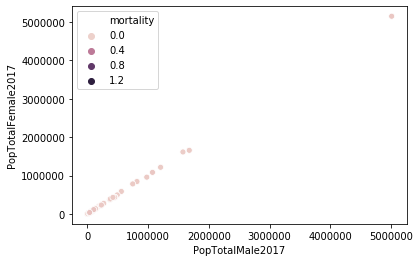

In [93]:

sns.scatterplot(X_ca_pop['PopTotalMale2017'],X_ca_pop['PopTotalFemale2017'], Y_ca_pop)

In [94]:
import plotly.offline as py
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import cufflinks as cf
cf.set_config_file(offline=True, sharing=False, theme='ggplot');

##### *California*

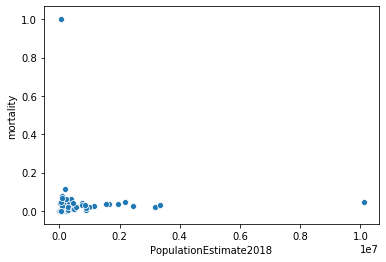

In [95]:
sns.scatterplot(ca_cases['PopulationEstimate2018'], ca_cases['mortality'])

In [97]:
# isolate and identify the outliers
print(ca_cases[ca_cases['PopulationEstimate2018'] > 10000000]['CountyName'])

print(ca_cases[ca_cases['mortality'] > 0.8]['CountyName'])

204    Los Angeles
Name: CountyName, dtype: object
237    Tehama
Name: CountyName, dtype: object


In [99]:
ca_cases

,FIPS,Province_State,Lat,Long,total_confirmed,total_deaths,mortality,CountyName,PopulationEstimate2018,PopTotalMale2017,...,#HospParticipatinginNetwork2017,#Hospitals,#ICU_beds,stay at home,>50 gatherings,>500 gatherings,public schools,restaurant dine-in,entertainment/gym,SVIPercentile
186,06001,California,37.646294,-121.892927,1114,41,0.036804,Alameda,1666753.0,817903.0,...,6.0,12.0,282.0,2020-03-19,2020-03-19,2020-03-19,2020-03-19,2020-03-15,2020-03-15,0.4701
187,06003,California,38.596786,-119.822359,2,0,0.000000,Alpine,1101.0,610.0,...,0.0,0.0,0.0,2020-03-19,2020-03-19,2020-03-19,2020-03-19,2020-03-15,2020-03-15,0.7287
188,06005,California,38.445831,-120.656960,7,0,0.000000,Amador,39383.0,20839.0,...,1.0,1.0,6.0,2020-03-19,2020-03-19,2020-03-19,2020-03-19,2020-03-15,2020-03-15,0.5334
189,06007,California,39.667278,-121.600525,16,0,0.000000,Butte,231256.0,113398.0,...,0.0,4.0,43.0,2020-03-19,2020-03-19,2020-03-19,2020-03-19,2020-03-15,2020-03-15,0.8064
190,06009,California,38.205371,-120.552913,12,0,0.000000,Calaveras,45602.0,22754.0,...,0.0,1.0,0.0,2020-03-19,2020-03-19,2020-03-19,2020-03-19,2020-03-15,2020-03-15,0.2350
191,06011,California,39.178820,-122.233173,3,0,0.000000,Colusa,21627.0,11156.0,...,0.0,1.0,0.0,2020-03-19,2020-03-19,2020-03-19,2020-03-19,2020-03-15,2020-03-15,0.7436
192,06013,California,37.919235,-121.928953,685,19,0.027737,Contra Costa,1150215.0,560863.0,...,5.0,7.0,163.0,2020-03-19,2020-03-19,2020-03-19,2020-03-19,2020-03-15,2020-03-15,0.4057
193,06015,California,41.742283,-123.897406,2,0,0.000000,Del Norte,27828.0,14784.0,...,1.0,1.0,6.0,2020-03-19,2020-03-19,2020-03-19,2020-03-19,2020-03-15,2020-03-15,0.9713
194,06017,California,38.779660,-120.523317,36,0,0.000000,El Dorado,190678.0,94342.0,...,0.0,2.0,28.0,2020-03-19,2020-03-19,2020-03-19,2020-03-19,2020-03-15,2020-03-15,0.1838
195,06019,California,36.757339,-119.646695,311,7,0.022508,Fresno,994400.0,493547.0,...,2.0,7.0,164.0,2020-03-19,2020-03-19,2020-03-19,2020-03-19,2020-03-15,2020-03-15,0.9611


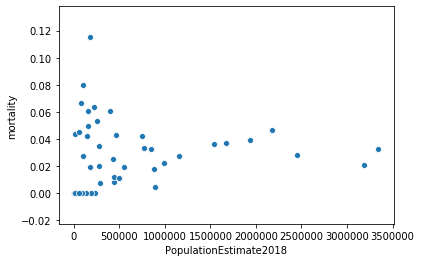

In [101]:
# We can see what the result of removing these outliers is on the visualization
ca_cases_no_outlier = ca_cases[ca_cases['PopulationEstimate2018'] < 10000000]
ca_cases_no_outlier = ca_cases_no_outlier[ca_cases_no_outlier['mortality'] < 0.8]

sns.scatterplot(ca_cases_no_outlier['PopulationEstimate2018'], ca_cases_no_outlier['mortality'])

In [102]:
fig = go.Figure()
ca_pop_gender_scatter = go.Scatter3d(x=ca_cases_no_outlier['PopTotalMale2017'],y=ca_cases_no_outlier['PopTotalFemale2017'],z=ca_cases_no_outlier['mortality'], mode='markers',marker=dict(size=2))
fig.add_trace(ca_pop_gender_scatter)
fig.update_layout(margin=dict(l=0,r=0,t=0,b=0),height=600)
fig

In [103]:
model = LinearRegression()
model.fit(ca_cases_no_outlier[["PopTotalMale2017", "PopTotalFemale2017"]], ca_cases_no_outlier[["mortality"]])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [104]:
def plot_plane(f, X, grid_points = 30):
    u = np.linspace(X[:,0].min(),X[:,0].max(), grid_points)
    v = np.linspace(X[:,1].min(),X[:,1].max(), grid_points)
    xu, xv = np.meshgrid(u,v)
    X = np.vstack((xu.flatten(),xv.flatten())).transpose()
    z = f(X)
    return go.Surface(x=xu, y=xv, z=z.reshape(xu.shape),opacity=0.8)

In [106]:
fig = go.Figure()
fig.add_trace(ca_pop_gender_scatter)
fig.add_trace(plot_plane(model.predict, ca_cases_no_outlier[["PopTotalMale2017", "PopTotalFemale2017"]].to_numpy(), grid_points=5))
fig.update_layout(margin=dict(l=0, r=0, t=0, b=0), 
                  height=600)